# **Curating metal-organic frameworks to compose robust gas sensor arrays in dilute conditions**

### Arni Sturluson, Rachel Sousa, Yujing Zhang, Melanie T. Huynh, Caleb Laird, Arthur H. P. York, Carson Silsby, Chih-Hung Chang, and Cory M. Simon

==========================================================================================

In this Notebook we will by analyzing how to choose  different pairs of MOFs can be accurately determine  the composition of CO<sub>2</sub> and SO<sub>2</sub> when they are coated on a Quartz Crystal Microbalance (QCM) to be employed in a sensor array.

To do this we will inspect the CO<sub>2</sub> and SO<sub>2</sub> adsorption isotherms of each MOF and extract the Henry coefficients from each isotherm (See `Extract_Henry.ipynb`) and form a Henry coefficient matrix, <b>H</b>. The <i>Singular Value Decomposition</i> (SVD) is used to factorize <b>H</b> into three matrices that will aid us in analyzing the performance of each MOF pair.

The MOF adsorption data was gathered from various sources. See full citation list at the bottom of the notebook (or click [here](#ref_list))

| MOF | CO<sub>2</sub> Reference | SO<sub>2</sub> Reference |
| :--- |    :----:      | :----:         |
|MFM-600| 10.1021/jacs.8b08433 | 10.1021/jacs.8b08433 |
|MFM-601| 10.1021/jacs.8b08433 | 10.1021/jacs.8b08433 |
|Mg-MOF-74| 10.1021/cm401270b | 10.1039/c1ee01720a |
|Ni(bdc)(ted)<sub>0.5</sub>| 10.1021/cm401270b | 10.1016/j.micromeso.2009.11.026 |
|Zn(bdc)(ted)<sub>0.5</sub>| 10.1021/cm401270b | 10.1016/j.micromeso.2009.11.026 |
|MFM-300(In)| 10.1002/adma.201602338 | 10.1002/adma.201602338 |
|NOTT-202a | 10.1021/ja401061m | 10.1021/ja401061m |
|NOTT-300 | 10.1038/nchem.1457 | 10.1038/nchem.1457 |
|Co<sub>3</sub>[Co(CN)<sub>6</sub>]<sub>2</sub> | 10.1021/ic902397w | 10.1021/ic902397w |
|Zn<sub>3</sub>[Co(CN)<sub>6</sub>]<sub>2</sub> | 10.1021/ic902397w | 10.1021/ic902397w |
|KAUST-7 | 10.1038/s41467-019-09157-2 | 10.1038/s41467-019-09157-2 |
|KAUST-8 | 10.1038/s41467-019-09157-2 | 10.1038/s41467-019-09157-2 |

In [1]:
using Optim
using CSV
using DataFrames
using PyPlot
using LaTeXStrings
using Printf
using LinearAlgebra
using Statistics

┌ Info: Recompiling stale cache file /home/sturlusa/.julia/compiled/v1.1/Optim/R5uoh.ji for Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/sturlusa/.julia/compiled/v1.1/CSV/HHBkp.ji for CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1184


The .csv file `../data/henry_constants.csv` contains all the Henry coefficients extraced from `Extract_Henry.ipynb`

In [2]:
df_henry = CSV.read("../data/henry_constants.csv")

,crystal,CO2_henry coefficient [mmol/(g-bar)],CO2_Temperature [K],SO2_henry coefficient [mmol/(g-bar)],SO2_Temperature [K]
,String⍰,Float64⍰,Int64⍰,Float64⍰,Int64⍰
1,MFM601,1.3703,298,97.2407,298
2,Zn-bdc-ted,2.15867,298,19.1696,298
3,Ni-bdc-ted,2.2069,298,40.402,298
4,NOTT-202a,3.27573,293,153.6,293
5,MFM600,1.41883,298,34.7973,298
6,NOTT-300,7.96526,293,483.864,293
7,MFM-300-In,4.60751,298,171.432,298
8,Zn-CN6,5.17058,298,4.36483,298
9,Mg-MOF-74,198.82,293,150.413,298


The QCM-MOF sensors recognize change in mass adsorbed on the MOF coating layer. Thus, we will add two columns to the dataframe with the Henry coefficient units to `g gas / (bar-g MOF)`

In [3]:
mw = Dict("CO2" => 44.01, "SO2" => 64.066)
for gas in ["CO2", "SO2"]
    df_henry[Symbol("H_$gas [g/(g-bar)]")] = df_henry[Symbol(gas * "_henry coefficient [mmol/(g-bar)]")] * mw[gas] / 1000
end

first(df_henry)

,crystal,CO2_henry coefficient [mmol/(g-bar)],CO2_Temperature [K],SO2_henry coefficient [mmol/(g-bar)],SO2_Temperature [K],H_CO2 [g/(g-bar)],H_SO2 [g/(g-bar)]
,String⍰,Float64⍰,Int64⍰,Float64⍰,Int64⍰,Float64,Float64
1,MFM601,1.3703,298,97.2407,298,0.0603069,6.22982


This Dict will provide a cleaner looking LaTeX string to use in plots for better looking visualizations.

In [4]:
formatted_crystal_names = Dict{AbstractString, AbstractString}()
formatted_crystal_names["MFM601"] = "MFM-601"
formatted_crystal_names["Zn-bdc-ted"] = "Zn(bdc)(ted)\$_{0.5}\$"
formatted_crystal_names["Ni-bdc-ted"] = "Ni(bdc)(ted)\$_{0.5}\$"
formatted_crystal_names["NOTT-202a"] = "NOTT-202a"
formatted_crystal_names["MFM600"] = "MFM-600"
formatted_crystal_names["NOTT-300"] = "NOTT-300"
formatted_crystal_names["MFM-300-In"] = "MFM-300-In"
formatted_crystal_names["Zn-CN6"] = "Zn\$_3\$[Co(CN)\$_6\$]\$_2\$"
formatted_crystal_names["Mg-MOF-74"] = "Mg-MOF-74"
formatted_crystal_names["Co-CN6"] = "Co\$_3\$[Co(CN)\$_6\$]\$_2\$"
formatted_crystal_names["KAUST7"] = "KAUST-7"
formatted_crystal_names["KAUST8"] = "KAUST-8"

"KAUST-8"

Lets create the Henry coefficient matrix, <b>H</b>, and see how it maps <b>p</b> to __m__, or alternatively, how it maps from _composition space_ to _response space_.

`mof2index` is a helper function that maps the name of a MOF to its index in the dataframe.

In [5]:
construct_H_matrix(mofs::Array{Int64, 1}, gases::Array{<:AbstractString, 1}) = [df_henry[mof, Symbol("H_" * gas * " [g/(g-bar)]")] for mof in mofs, gas in gases]
construct_H_matrix([7, 9], ["SO2", "CO2"])

2×2 Array{Float64,2}:
 10.983    0.202777
  9.63634  8.75008 

In [6]:
function mof2index(mof::AbstractString)
    mask = mof .== df_henry[:crystal]
    if sum(mask) > 1
        @error "More than one MOF match the given MOF name"
    elseif sum(mask) == 0
        @error "No MOF matched the given MOF name"
    else
        return argmax(mask)
    end
end
mof1 = mof2index("MFM-300-In")
mof2 = mof2index("Mg-MOF-74")
construct_H_matrix([mof1, mof2], ["SO2", "CO2"])

2×2 Array{Float64,2}:
 10.983    0.202777
  9.63634  8.75008 

# Singular Value Decomposition (SVD)
Now we will factorize <b>H</b> using SVD: <br>
<b>H</b> = <b>U&Sigma;V<sup>T</sup></b> <br>
where;<br> 
<b>U</b> = [<b>u<sub>1</sub>u<sub>2</sub></b>] is an orthogonal matrix with columns that span the column space of <b>H</b>. The columns in <b>U</b> are the left singular vectors of <b>H</b>. <br>
<b>&Sigma;</b> is a diagonal matrix containing the singular values of <b>H</b>; &sigma;<sub>1</sub> and &sigma;<sub>2</sub>, running down the diagonal in non-increasing order. The singular values are linked to the singular vectors and govern their importance. <br>
<b>V</b> = [<b>v<sub>1</sub>v<sub>2</sub></b>] is an orthogonal matrix with columns that span the row space of <b>H</b>. The columns in <b>V</b> are the right singular vectors of <b>H</b>. <br><br>
The mapping from composition space to response space by <b>H</b> can be broken down into three transformations: An orthogonal transformation (<b>U</b>), scaling (<b>&Sigma;</b>), and another orthogonal transformation (<b>V<sup>T</sup></b>). <br>
To visualize the three transformations, we will map a circle in composition to an ellipse in response space.

In [7]:
function plot_response(mofs::Array{Int64, 1}, gases::Array{<:AbstractString, 1})
    H = construct_H_matrix(mofs, gases) ./ 1e6 * 1000 # bar->ppm and g->mg [mg/g-ppm]
        
    # Decompose `H` with SVD. `F` stores U, Σ, V and Vᵀ
    F = svd(H)
    # `θ` and `p` are used to plot a unit circle in composition space
    θ = range(0, stop=2*π, length=500)
    p = 500 .* transpose(hcat(cos.(θ), sin.(θ))) # The radius of the circle will be 500 ppm
    # The matrix H maps the partial pressures `p` to a response `n`
    n = H * p # [mg/g]
    
    # A nested function to plot eigenvectors from the SVD decomposition
    #TODO Fix `head_width` to scale with response
    function plot_vector(x; width=0.001, head_length=0.05, head_width=0.05, color="k", label="", label_dist=0.05)
        x_plot = x - head_length * x / norm(x)
        plt.arrow(0, 0, x_plot[1], x_plot[2], width=width, head_width=head_width,
            head_length=head_length, fc=color, ec=color, zorder=1000000)
        x_label = x + x / norm(x) * label_dist
        plt.text(x_label[1], x_label[2], label)
    end

    # A colormap is grabbed from matplotlib.colors and is normalized with respect to our data
    cnorm = PyPlot.matplotlib.colors.Normalize(vmin=0.0, vmax=2 * π)
    m = plt.cm.ScalarMappable(norm=cnorm, cmap=plt.cm.hsv)
    m.set_array([])
    
    plt.figure(figsize=(11, 6))
    
    #########################
    ### Composition Space ###
    #########################
    
    ax = plt.subplot(121, aspect="equal")
    r = range(0.01, stop=1.0, length=40)
    # The circle in composition space is plotted
    for j in 1:length(r)
        p_bar = r[j] .* p
        plt.scatter(p_bar[1, :], p_bar[2, :], lw=5, c=m.to_rgba(θ))
        if mod(j,10) == 0
            for i in 1:length(θ)-1
                plt.plot(p_bar[1, i:i+1], p_bar[2, i:i+1], lw=1, c="k", alpha=0.5)
            end
        end
    end
    
    plt.axis("equal")
    plt.xlabel(@sprintf("\$p_{%s}^*\$ (ppm)", gases[1]))
    plt.ylabel(@sprintf("\$p_{%s}^*\$ (ppm)", gases[2]), rotation=0)

    # The vectors v₁ and v₂ are plotted
    for k = 1:2
        plot_vector(500 * F.V[:, k], color="k", head_width=35., head_length=20.,
            label="\$\\mathbf{v}_$k\$", label_dist=50.)
    end
    
    # The following calls are used to shift and modify the axes    
    ax.xaxis.tick_bottom()
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("bottom")
    ax.spines["right"].set_position("zero")
    ax.spines["left"].set_color("none")
    ax.yaxis.tick_right()
    ax.spines["top"].set_position("zero")
    ax.spines["bottom"].set_color("none")
    ax.set_axisbelow(false)
    # Shift the axis labels to a more fitting position
    ax.xaxis.set_label_coords(-0.05, 0.55)
    ax.yaxis.set_label_coords(0.60, 0.97)        
    
    
    plt.title("Composition Space")
    plt.tight_layout()
    
    ######################
    ### Response Space ###
    ######################
    
    ax = plt.subplot(122, aspect="equal")
    
    # The ellipse in response space is plotted
    for i = 1:length(θ)-1
        plt.plot(n[1, i:i+1], n[2, i:i+1], lw=5, c=m.to_rgba(mean(θ[i:i+1])))
    end
    
    # The black "height" lines are plotted
    for j in 1:length(r)
        p_bar = r[j] .* p
        n_bar = H * p_bar
        plt.scatter(n_bar[1, :], n_bar[2, :], lw=5, c=m.to_rgba(θ))
        if mod(j,10) == 0
            for i in 1:length(θ)-1
                plt.plot(n_bar[1, i:i+1], n_bar[2, i:i+1], lw=1, c="k", alpha=0.5)
            end
        end
    end

    # The vectors σ₁u₁ and σ₂u₂ are plotted
    for k = 1:2
        plot_vector(F.U[:, k] * F.S[k] * 500, head_length=0.25, width=0.05,
            head_width=0.35, color="k", label="\$\\sigma_$k\\mathbf{u}_$k\$", label_dist=0.85)
    end
    
    # The following calls are used to shift and modify the axes        
    ax.yaxis.tick_right()
    ax.yaxis.set_ticks_position("right")
    ax.yaxis.set_label_position("right")
    ax.xaxis.tick_bottom()
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("bottom")
    ax.spines["left"].set_position("zero")
    ax.spines["right"].set_color("none")
    ax.yaxis.tick_left()
    ax.spines["top"].set_position("zero")
    ax.spines["bottom"].set_color("none")
    ax.set_axisbelow(false)
    # Shift the axis labels to a more fitting position
    ax.xaxis.set_label_coords(1.05, 0.55)
    ax.yaxis.set_label_coords(0.67, 1.00)        
    
    plt.axis("equal")
    plt.xlabel(@sprintf("\$m_{%s}^*\$ [mg/g]", df_henry[:crystal][mofs[1]]))
    plt.ylabel(@sprintf("\$m_{%s}^*\$ [mg/g]", df_henry[:crystal][mofs[2]]), rotation=0)
    plt.title("Response Space")
    plt.tight_layout()
    
    
    plt.savefig(@sprintf("composition_response_of_%i_and_%i.png", mofs[1], mofs[2]), format="png", dpi=300)
end

plot_response(mofs::Array{<:AbstractString, 1}, gases::Array{<:AbstractString, 1}) = plot_response(mof2index.(mofs), gases)

plot_response (generic function with 2 methods)

Lets see how a pair of MOFs in a sensor array respond to a change in gas composition:

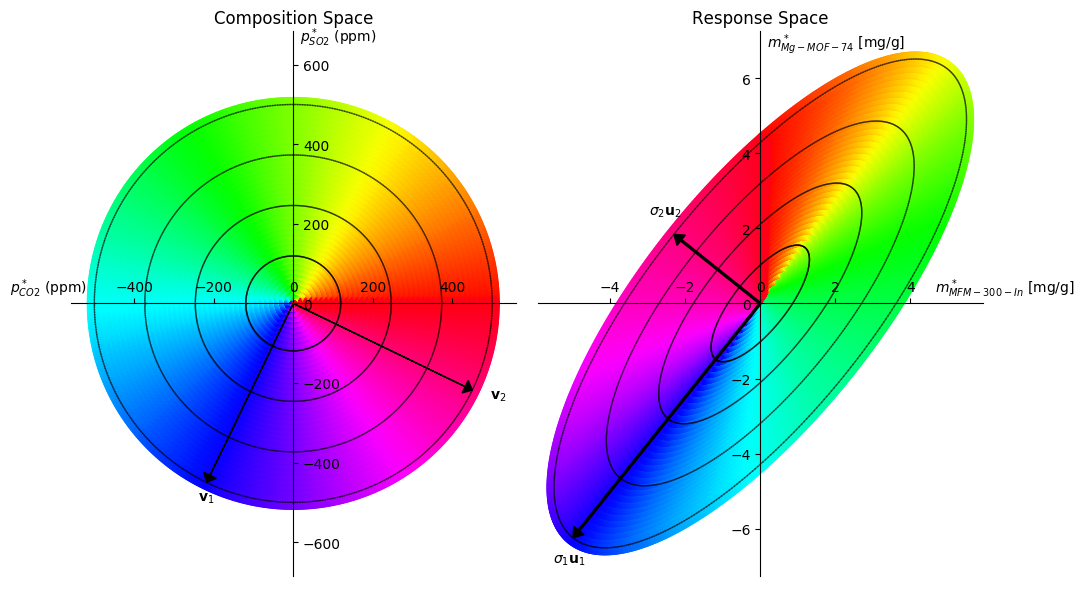

In [8]:
plot_response(["MFM-300-In", "Mg-MOF-74"], ["CO2", "SO2"])

# Error analysis
The mapping of MFM-300-In and Mg-MOF-74 (shown above) is well-conditioned, meaning that the <b>H</b> formed for the pair does far from being singular. The ellipse generated by an ill-conditioned <b>H</b> will be thin, coming close to being a line. The ellipse of a well-conditioned <b>H</b> will have a wide ellipse, such as the one above.<br>
This tells us that the same change in composition space will be mapped to two differently sized responses depending on the conditioning of <b>H</b>. <br>
To try to visualize the effects an ill-conditioned <b>H</b> has on a sensor array, we will map two MOF pairs, one robust and one poor, from composition space to response space and compare the two. Additionally, we will map the limit of detection of the QCM-MOF sensors from response space to composition space using the inverse of the Henry coefficient matrix, <b>H<sup>-1</sup></b>.

In [9]:
function plot_reverse_mapping(mofs::Array{Array{Int64, 1}, 1}, gases::Array{<:AbstractString, 1})
    # We need two H matrices for the two MOF pairs
    H1 = construct_H_matrix(mofs[1], gases)
    H2 = construct_H_matrix(mofs[2], gases)
    
    colors = ["#3cb44b", "#911eb4"]
    labels = [
        @sprintf("Robust Pair: {%s (1) and %s (2)}", formatted_crystal_names[df_henry[:crystal][mofs[1][1]]], formatted_crystal_names[df_henry[:crystal][mofs[1][2]]]), 
        @sprintf("Poor Pair: {%s (1) and %s (2)}", formatted_crystal_names[df_henry[:crystal][mofs[2][1]]], formatted_crystal_names[df_henry[:crystal][mofs[2][2]]])
             ]
    zorders = [2.2, 1]
    
    H1 = H1 * 1e6 / 1e6 # g->μg and bar->ppm
    H2 = H2 * 1e6 / 1e6 # g->μg and bar->ppm
    
    # Make sure that the more robust MOF pair is green and has the correct label associated with it
    if cond(H1) > cond(H2)
        colors[1], colors[2] = colors[2], colors[1]
        labels[1], labels[2] = labels[2], labels[1]
        zorders[1], zorders[2], zorders[2], zorders[1]
    end
    
    # We use the same method as in the `plot_response` function. 
    # We need a few more variables to keep track of in this function: 
    # n_err: the error zone circle
    # p1, p2: composition ellipses for the two MOF pairs
    # n1, n2: response ellipses for the two MOF pairs
    # p: composition circle
    θ = range(0, stop=2*π, length=200)
    n_err = 15. .* transpose(hcat(cos.(θ), sin.(θ)))
    p1 = inv(H1) * n_err
    p2 = inv(H2) * n_err
    p = 5 .* transpose(hcat(cos.(θ), sin.(θ)))
    n1 = H1 * p
    n2 = H2 * p

    # a,b are used to make a meshgrid (assigned to X and Y)
    # We use a Gaussian distribution to model the error zone. σ parameter chosen arbitrarily.
    a = range(-45,stop=45,length=201)
    b = range(-45,stop=45,length=201)
    X = [i for i in a, j in b]
    Y = [j for i in a, j in b]
    σ = 30
    z = (sqrt(2 * π * σ^2))^(-1) .* exp.(-(X.^2 .+ Y.^2) ./ (2 * σ))
    levels = PyPlot.matplotlib.ticker.MaxNLocator(nbins=100).tick_values(minimum(z), maximum(z))
    cmap = plt.get_cmap("YlOrRd")
    my_cmap = cmap(1:cmap.N)
    # Here I rigged a colormap to become transparent at one end
    for i = 1:10
        my_cmap[i, 4] = 0.1 * (i-1)
    end
    my_cmap = PyPlot.matplotlib.colors.ListedColormap(my_cmap)
    norm1 = PyPlot.matplotlib.colors.BoundaryNorm(levels, ncolors=my_cmap.N, clip=true)

    fig = plt.figure(figsize=(12, 5.5))
    
    ##########################
    ######  Top Figure  ######
    ##########################
    
    ##########
    ### Left #
    ##########

    ax = plt.subplot(121, aspect="equal")  
    plt.plot(p[1,:], p[2,:], lw=4, c="k")
    plt.xlabel("\$p^*_{CO_2}\$ (ppm)")
    plt.ylabel("\$p^*_{SO_2}\$ (ppm)", rotation = 0)
    ax.xaxis.tick_bottom()
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("bottom")
    ax.spines["left"].set_position("zero")
    ax.spines["right"].set_color("none")
    ax.yaxis.tick_left()
    ax.xaxis.set_label_coords(-0.15, 0.55)
    ax.yaxis.set_label_coords(0.6, 0.95)    
    ax.spines["top"].set_position("zero")
    ax.spines["bottom"].set_color("none")
    ax.set_axisbelow(false)
    ax.set_xlim([-10, 10])
    ax.set_ylim([-10, 10])
    
    plt.title("Composition Space")
    
    ###########
    # Right ###
    ###########
      
    ax = plt.subplot(122, aspect="equal")

    plt.plot(n1[1,:], n1[2,:], lw=4, c=colors[1], zorder=zorders[1])
    plt.plot(n2[1,:], n2[2,:], lw=4, c=colors[2], zorder=zorders[2])
    ax.pcolormesh(X, Y, z, cmap=my_cmap, norm=norm1)

    plt.xlabel("\$m^*_{MOF_1}\$ (μg/g)")
    plt.ylabel("\$m^*_{MOF_2}\$ (μg/g)", rotation = 0)    
    ax.yaxis.set_ticks_position("right")
    ax.yaxis.set_label_position("right")
    ax.xaxis.tick_bottom()
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("bottom")
    ax.spines["left"].set_position("zero")
    ax.spines["right"].set_color("none")
    ax.yaxis.tick_left()
    ax.xaxis.set_label_coords(1.05, 0.56)
    ax.yaxis.set_label_coords(0.61, 0.99)        
    ax.spines["top"].set_position("zero")
    ax.spines["bottom"].set_color("none")
    ax.set_axisbelow(false)
    ax.set_xlim([-75, 75])
    ax.set_ylim([-75, 75])
    
    plt.title("Response Space")
        
    # Add an arrow showing the mapping by overlaying a new subplot on the figure
    ax = fig.add_subplot(111)
    plt.xlim([0,11])
    plt.ylim([-5,5])
    plt.arrow(4.875, 2.5, 1.1, 0.0, color="k", width=0.01, head_width=0.1, zorder=9999)
    plt.text(5.3, 2.6, "\$\\mathbf{H}\$", fontsize=20)
    ax.axis("off")
    # A rigged legend using Line2D objects
    custom_lines = [PyPlot.matplotlib.lines.Line2D([0], [0], color=colors[1], lw=4),
                    PyPlot.matplotlib.lines.Line2D([0], [0], color=colors[2], lw=4)]
    ax.legend(custom_lines, labels, loc=8, handlelength=5)
    
    
    plt.tight_layout()
    plt.savefig("reverse_mapping_a.pdf", dpi=300, format="pdf")
    plt.show()
    
    
    fig = plt.figure(figsize=(12, 5.5))
    
    ############################
    ###### Bottom Figure  ######
    ############################
        
    ##########
    ### Left #
    ##########

    ax = plt.subplot(121, aspect="equal")
    plt.plot(p1[1,:], p1[2,:], lw=4, c=colors[1], zorder=zorders[1])
    plt.plot(p2[1,:], p2[2,:], lw=4, c=colors[2], zorder=zorders[2])
    plt.xlabel("\$p^*_{CO_2}\$ (ppm)")
    plt.ylabel("\$p^*_{SO_2}\$ (ppm)", rotation = 0)
    ax.xaxis.tick_bottom()
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("bottom")
    ax.spines["left"].set_position("zero")
    ax.spines["right"].set_color("none")
    ax.yaxis.tick_left()
    ax.xaxis.set_label_coords(-0.15, 0.55)
    ax.yaxis.set_label_coords(0.6, 0.95)    
    ax.spines["top"].set_position("zero")
    ax.spines["bottom"].set_color("none")
    ax.set_axisbelow(false)
    ax.set_xlim([-10, 10])
    ax.set_ylim([-10, 10])

    plt.title("Composition Space")
    
    ###########
    # Right ###
    ###########
    
    ax = plt.subplot(122, aspect="equal")
    ax.set_ylim([-15, 15])    
    plt.plot(n_err[1,:], n_err[2,:], lw=4, c="k", label="Error zone")
    ax.pcolormesh(X, Y, z, cmap=my_cmap, norm=norm1)

    plt.xlabel("\$m^*_{MOF_1}\$ (μg/g)")
    plt.ylabel("\$m^*_{MOF_2}\$ (μg/g)", rotation = 0)
    ax.yaxis.set_ticks_position("right")
    ax.yaxis.set_label_position("right")
    ax.xaxis.tick_bottom()
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("bottom")
    ax.spines["left"].set_position("zero")
    ax.spines["right"].set_color("none")
    ax.yaxis.tick_left()
    ax.xaxis.set_label_coords(1.05, 0.56)
    ax.yaxis.set_label_coords(0.61, 0.99)        
    ax.spines["top"].set_position("zero")
    ax.spines["bottom"].set_color("none")
    ax.set_axisbelow(false) 
    ax.set_xlim([-75, 75])
    ax.set_ylim([-75, 75])
    
    plt.title("Response Space")
    

    # Add an arrow showing the mapping by overlaying a new subplot on the figure    
    ax = fig.add_subplot(111)
    ax.set_xlim([0,11])
    ax.set_ylim([-5,5])
    plt.arrow(6.25, 2.5, -1.1, 0.0, color="k", width=0.01, head_width=0.1, zorder=9999)
    plt.text(5.25, 2.6, "\$\\mathbf{H}^{-1}\$", fontsize=20)
    ax.axis("off")

    plt.tight_layout()
    plt.savefig("reverse_mapping_b.pdf", dpi=300, format="pdf")
    plt.show()
end
plot_reverse_mapping(mofs::Array{Array{String, 1}, 1}, gases::Array{<:AbstractString, 1}) = plot_reverse_mapping([mof2index.(mofs[1]), mof2index.(mofs[2])], gases)

plot_reverse_mapping (generic function with 2 methods)

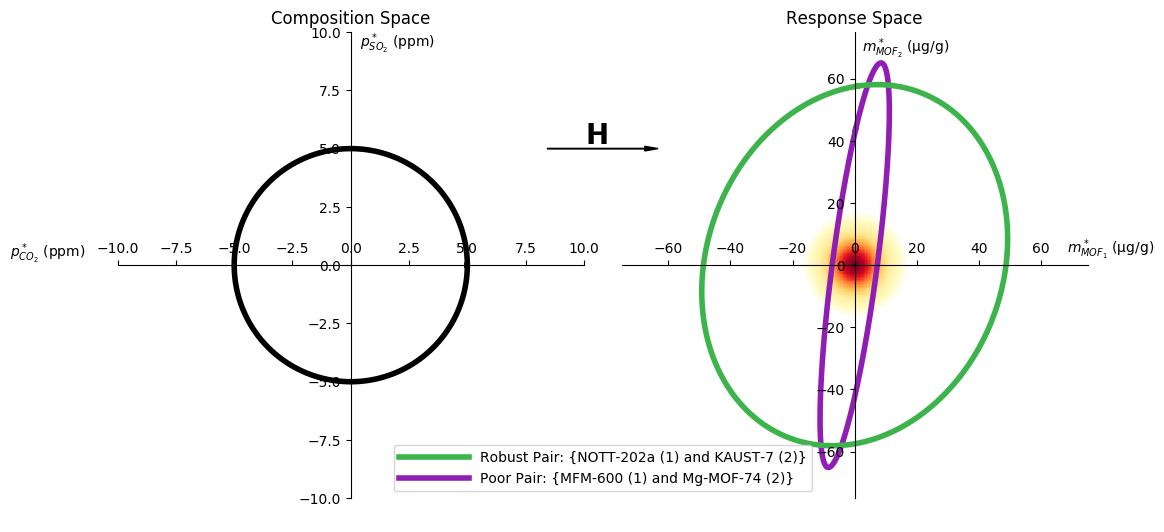

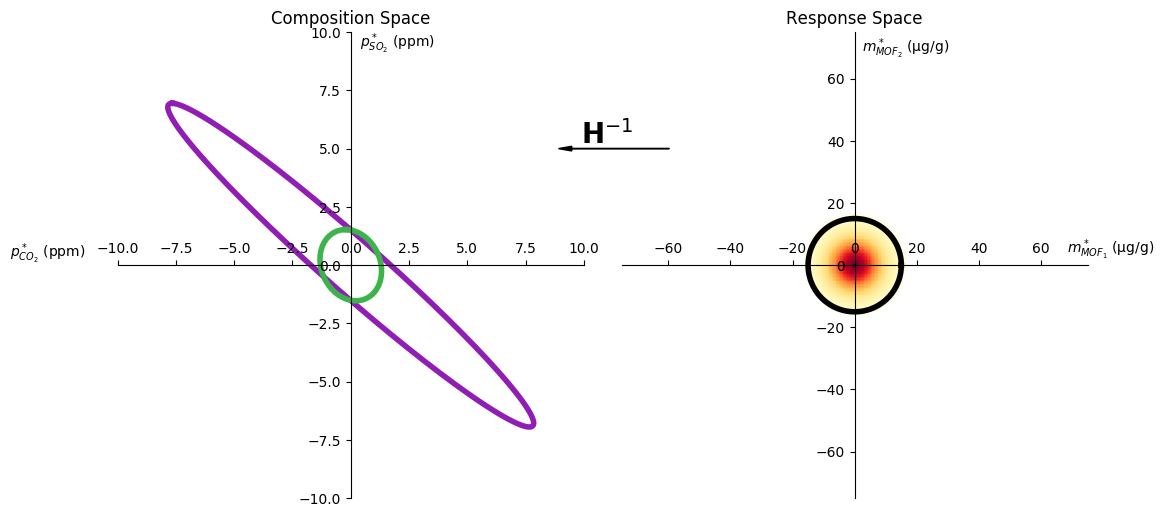

In [10]:
plot_reverse_mapping([["NOTT-202a","KAUST7"],["MFM600","Mg-MOF-74"]], ["CO2", "SO2"])

Here we lay down the groundwork for our SVD analysis<br />
We begin by constructing a matrix, **H**, containing the Henry coefficients for the gas-MOF pair we are interested in

Lets look at the response generated by every combination of 2 MOFs from our subset of MOFs:

In [81]:
function plot_all_responses(gases::Array{<:AbstractString, 1}, indicator_type::Symbol=:sigma2)
    θ = range(0, stop=2*π, length=1000)
    p = transpose(hcat(cos.(θ), sin.(θ)))
    n_mofs = length(df_henry[:crystal])
    height_ratios = ones(2*n_mofs) * 1.25
    width_ratios = ones(n_mofs)
    hspace = 0.1
    for i = 1:2:2*n_mofs
        height_ratios[i] = 0.1
    end
    fig, axs = plt.subplots(nrows=2*n_mofs, ncols=n_mofs, figsize=(20, 20),
                    gridspec_kw = Dict("height_ratios" => height_ratios,
                                       "width_ratios" => width_ratios,
                                       "hspace" => hspace))
    mof_no = 0
    indicator = zeros(n_mofs, n_mofs)
    for i = 1:2:2*n_mofs
        for j = 1:n_mofs

            # The response generated by having two of the same MOFs is an underdetermined problem with infinite solutions
            if i+1 == 2*j
                #axs[i+1, j].set_facecolor("#a9a9a9")
                axs[i+1, j].set_xticks([])
                axs[i+1, j].set_yticks([])
                axs[i+1, j].axis("off")
                imgstring = @sprintf("../data/cif_viz/small_%s.jpg", df_henry[:crystal][ceil(Int,i/2)])
                println(imgstring)
                if isfile(imgstring)
                    img = PyPlot.matplotlib.image.imread(imgstring)
                    axs[i+1, j].imshow(img)
                end
                
                
            elseif i > 2*j
                axs[i,j].axis("off")
                axs[i+1,j].axis("off")
                continue
            else
                axs[i+1, j].set_xticks([])
                axs[i+1, j].set_yticks([])
                
                # Set ticks and labels on top right plot
                axs[2, n_mofs].set_xlabel("\$m_1\$ [mg/g]")
                axs[2, n_mofs].set_ylabel("\$m_2\$ [mg/g]", rotation=0)
                axs[2, n_mofs].xaxis.set_label_coords(0.93, 0.45)
                axs[2, n_mofs].yaxis.set_label_coords(0.85, 0.95)                
                axs[2, n_mofs].set_yticks([-0.02, 0.02])

                H = construct_H_matrix([ceil(Int, i/2), j], gases) * 1000 / 1e6 #g->mg, bar->ppm
                F = svd(H)
                n = H * p
                for k in 1:length(θ)-1
                    axs[i+1,j].plot(n[1, k:k+1], n[2, k:k+1], lw=2, c="r", zorder=1000)
                end
                if indicator_type == :area
                    indicator[ceil(Int,i/2), j] = π * F.S[1] * F.S[2]
                elseif indicator_type == :sigma1
                    indicator[ceil(Int,i/2), j] = F.S[1]
                elseif indicator_type == :sigma2
                    indicator[ceil(Int,i/2), j] = F.S[2]
                else
                    error("indicator_type not recognized. Try `:area`, `:sigma1` or `:sigma2`")
                end

                # Make the ellipse look nice plot
                axs[i+1, j].yaxis.tick_right()
                axs[i+1, j].yaxis.set_ticks_position("right")
                axs[i+1, j].yaxis.set_label_position("right")
                axs[i+1, j].xaxis.tick_bottom()
                axs[i+1, j].xaxis.set_ticks_position("top")
                axs[i+1, j].xaxis.set_label_position("bottom")
                axs[i+1, j].spines["left"].set_position("zero")
                axs[i+1, j].spines["right"].set_color("none")
                axs[i+1, j].yaxis.tick_left()
                axs[i+1, j].spines["top"].set_position("zero")
                axs[i+1, j].spines["bottom"].set_color("none")        
                axs[i+1, j].set_axisbelow(false)
                axs[i+1, j].axis("equal")
                        
            end
            
            if i == 1
                ttl = axs[i, j].set_title(formatted_crystal_names[df_henry[:crystal][j]], y=0.6)
                #ttl.set_position([.5, 1.05])
            end
            if 2*j == i+1
                    #axs[i+1, j].text(-125, 300, formatted_crystal_names[df_henry[:crystal][ceil(Int,i/2)]], 
                    #        size=12, verticalalignment = "center", rotation = 90)
            end
        end
    end
        
    best_ellipse = argmax(indicator)
    max_indicator = maximum(indicator)
    best_xlims = axs[best_ellipse[1]*2, best_ellipse[2]].get_xlim()
    best_ylims = axs[best_ellipse[1]*2, best_ellipse[2]].get_ylim()
    if (best_xlims[2]-best_xlims[1]) > (best_ylims[2]-best_ylims[1])
        best_ylims = best_xlims
    else
        best_xlims = best_ylims
    end
                
    for i = 1:2:2*n_mofs
        for j = 1:n_mofs
            if i+1 == 2*j || i > 2*j
                axs[i, j].axis("off")
                continue
            else
                # Fix the limits on the ellipse plots
                axs[i+1, j].set_xlim(best_xlims)
                axs[i+1, j].set_ylim(best_ylims)
                # Make a discrimination bar ("health bar")
                axs[i, j].axis("off")
                old_xlim = axs[i, j].get_xlim()
                old_ylim = axs[i, j].get_ylim()
                width = (old_xlim[2] - old_xlim[1]) * indicator[ceil(Int, i/2), j] / max_indicator
                rect = PyPlot.matplotlib.patches.Rectangle([old_xlim[1], old_ylim[1]], width,
                        old_ylim[2]-old_ylim[1])
                axs[i, j].add_patch(rect)
                axs[i, j].plot([old_xlim[1], old_xlim[1], old_xlim[2], old_xlim[2], old_xlim[1]], 
                                        [old_ylim[1], old_ylim[2], old_ylim[2], old_ylim[1], old_ylim[1]], 
                                        lw=3, color="k", zorder=999)
                axs[i, j].set_xlim(old_xlim)
                axs[i, j].set_ylim(old_ylim)  
            end
        end        
    end
    axs[best_ellipse[1]*2, best_ellipse[2]].set_facecolor("#ffe119")
                    
    # Bottom left plot
    new_ax = fig.add_subplot(223, aspect="equal")
    plt.plot(p[1,:], p[2,:], lw=8, c="k")
    plt.xlabel("\$p^*_{CO_2}\$ (ppm)", fontsize=20)
    plt.ylabel("\$p^*_{SO_2}\$ (ppm)", rotation = 0, fontsize=20)
    new_ax.xaxis.tick_bottom()
    new_ax.xaxis.set_ticks_position("top")
    new_ax.xaxis.set_label_position("bottom")
    new_ax.spines["left"].set_position("zero")
    new_ax.spines["right"].set_color("none")
    new_ax.spines["left"].set_linewidth(3.5)
    new_ax.yaxis.tick_left()
    new_ax.xaxis.set_label_coords(1.15, 0.55)
    new_ax.yaxis.set_label_coords(0.6, 0.95)    
    new_ax.spines["top"].set_position("zero")
    new_ax.spines["top"].set_linewidth(3.5)
    new_ax.spines["bottom"].set_color("none")
    new_ax.set_axisbelow(false)
    new_ax.set_xlim([-1.5, 1.5])
    new_ax.set_ylim([-1.5, 1.5])
    plt.tick_params(labelsize=18)

    new_ax2 = fig.add_subplot(111)
    new_ax2.set_xlim(-10, 10)
    new_ax2.set_ylim(-10, 10)
    new_ax2.arrow(-2.5, -2.5, 1.5, 1.5, color="k", width=0.1, head_width=0.5, zorder=9999)
    new_ax2.text(-2.5, -1.25, "\$\\mathbf{H}\$", fontsize=60)
    new_ax2.axis("off")
                    
    plt.tight_layout()
    plt.savefig("all_responses_" * string(indicator_type) * ".pdf", format="pdf")
    plt.show()
    return (max_indicator, [df_henry[:crystal][best_ellipse[1]], df_henry[:crystal][best_ellipse[2]]])
end

plot_all_responses (generic function with 3 methods)

In [ ]:
(max_area1, best_pair1) = plot_all_responses(["CO2", "SO2"])

In [14]:
function plot_3d_mapping(mofs::Array{Int64, 1}, gases::Array{<:AbstractString, 1})
    # We need two H matrices for the two MOF pairs
    H = construct_H_matrix(mofs, gases)
    
    H = H * 1e6 / 1e6 # g->μg and bar->ppm
    
    θ = range(0, stop=2*π, length=100)
    p = 5 .* transpose(hcat(cos.(θ), sin.(θ)))
    n = H * p

    fig = plt.figure(figsize=(12, 5.5))
    
    ##########
    ### Left #
    ##########

    ax = plt.subplot(121, aspect="equal")  
    plt.plot(p[1,:], p[2,:], lw=4, c="k")
    plt.xlabel("\$p^*_{CO_2}\$ (ppm)")
    plt.ylabel("\$p^*_{SO_2}\$ (ppm)", rotation = 0)
    ax.xaxis.tick_bottom()
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("bottom")
    ax.spines["left"].set_position("zero")
    ax.spines["right"].set_color("none")
    ax.yaxis.tick_left()
    ax.xaxis.set_label_coords(-0.15, 0.55)
    ax.yaxis.set_label_coords(0.6, 0.95)    
    ax.spines["top"].set_position("zero")
    ax.spines["bottom"].set_color("none")
    ax.set_axisbelow(false)
    ax.set_xlim([-10, 10])
    ax.set_ylim([-10, 10])
    
    plt.title("Composition Space")
    
    ###########
    # Right ###
    ###########
    using3D()
    ax = plt.subplot(122, aspect="equal", projection="3d")

    ax.plot3D(n[1,:], n[2,:], n[3,:], lw=4, c="red", zorder=999)
    
    
    #ax.pcolormesh(X, Y, z, cmap=my_cmap, norm=norm1)

    xlabel("\$m^*_{MOF_1}\$ (μg/g)")
    ylabel("\$m^*_{MOF_2}\$ (μg/g)")    
    zlabel("\$m^*_{MOF_3}\$ (μg/g)")
    old_xlim = ax.get_xlim()
    old_ylim = ax.get_ylim()
    old_zlim = ax.get_zlim()
    if old_xlim[2] - old_xlim[1] > old_ylim[2] - old_ylim[1] && old_xlim[2] - old_xlim[1] > old_zlim[2] - old_zlim[1]
        println(1)
        ax.set_ylim(old_xlim)
        ax.set_zlim(old_xlim)
    elseif old_ylim[2] - old_ylim[1] > old_xlim[2] - old_xlim[1] && old_ylim[2] - old_ylim[1] > old_zlim[2] - old_zlim[1]
        println(2)
        ax.set_xlim(old_ylim)
        ax.set_zlim(old_ylim)
    else
        println(3)
        ax.set_xlim(old_zlim)
        ax.set_ylim(old_zlim)
    end
    
    #ax.plot3D(ax.get_xlim(), [0., 0.], [0., 0.], lw=1, c="k", zorder=9)
    ax.plot3D(n[1,:], n[2,:], fill(ax.get_xlim()[1], size(n[1,:])), lw=4, c="k", alpha=0.5, zorder=1)
    ax.plot3D(n[1,:], fill(ax.get_xlim()[1], size(n[1,:])), n[3,:], lw=4, c="k", alpha=0.5, zorder=1)
    ax.plot3D(fill(ax.get_xlim()[1], size(n[1,:])), n[2,:], n[3,:], lw=4, c="k", alpha=0.5, zorder=1)
            
    a = range(ax.get_xlim()[1], stop=ax.get_xlim()[2], length=50)        
    b = range(ax.get_xlim()[1], stop=ax.get_xlim()[2], length=50)
    X = [i for i in a, j in b]
    Y = [j for i in a, j in b]

    Z = fill(0.0, (50, 50))       

    #ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.15, zorder=999)
    #ax.plot_surface(Z, Y, X, rstride=1, cstride=1, alpha=0.15, zorder=999)
    #ax.plot_surface(Y, Z, X, rstride=1, cstride=1, alpha=0.15, zorder=999)

            
    ax.view_init(elev=45, azim=45)    
    plt.title("Response Space")
    
    #plt.tight_layout()
    plt.savefig("3d_mapping_a.png", dpi=300, format="png")
    plt.show()
end
plot_3d_mapping(mofs::Array{String, 1}, gases::Array{<:AbstractString, 1}) = plot_3d_mapping(mof2index.(mofs), gases)

plot_3d_mapping (generic function with 2 methods)

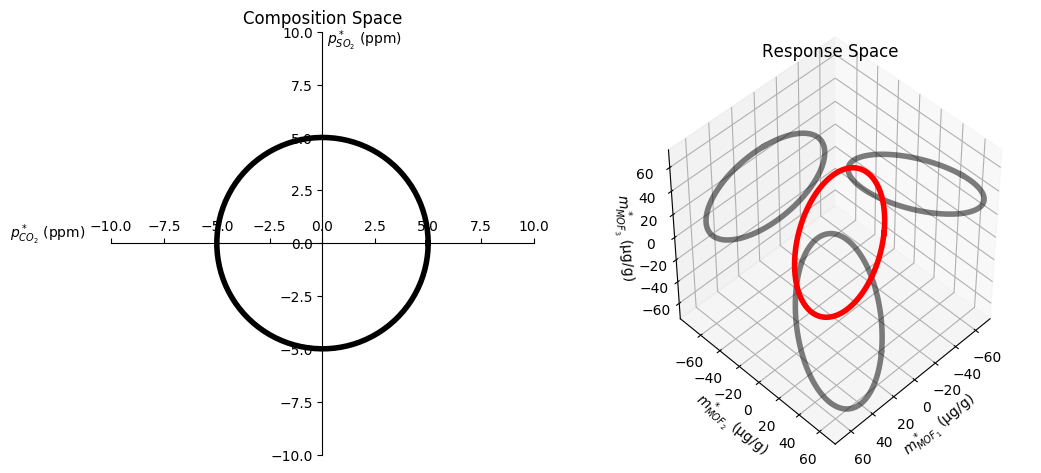

2


In [15]:
plot_3d_mapping(["MFM-300-In", "Mg-MOF-74", "KAUST8"], ["CO2", "SO2"])

In [16]:
H = construct_H_matrix(mof2index.(["MFM-300-In","Mg-MOF-74","KAUST8"]), ["CO2", "SO2"])
N = 10000
θ = range(0, stop=2*π, length=N)
p = 5 .* transpose(hcat(cos.(θ), sin.(θ)))
n = H * p
path = "visit_files/"

open(path * "ellipse.xyz", "w") do f
    @printf(f, "1050\nXYZ")
    for i = 1:N
        @printf(f, "\n%2s %.6f %.6f %.6f","He", n[1,i], n[2,i], n[3,i])
    end
    for i = 1:50
        @printf(f, "\n%2s %.6f %.6f %.6f","He", n[1,i], n[2,i], n[3,i])
    end
    
end

open(path * "ellipse_x.xyz", "w") do f
    @printf(f, "1000\nXYZ")
    for i = 1:N
        @printf(f, "\n%2s %.6f %.6f %.6f", "He", 99.000000, n[2,i], n[3,i])
    end
end

open(path * "ellipse_y.xyz", "w") do f
    @printf(f, "1000\nXYZ")
    for i = 1:N
        @printf(f, "\n%2s %.6f %.6f %.6f", "He", n[1,i], -99.000000, n[3,i])
    end
end

open(path * "ellipse_z.xyz", "w") do f
    @printf(f, "1000\nXYZ")
    for i = 1:N
        @printf(f, "\n%2s %.6f %.6f %.6f", "He", n[1,i], n[2,i], -99.000000)
    end
end
X = [-185 -185 185 185;
     -185 185 -185 185]
F = svd(H)
Y = F.U * F.Vt * X
#Y = H * X ./ 15
open(path * "plane.vtk", "w") do f
    @printf(f, "# vtk DataFile Version 2.0\nEllipse Plane\nASCII\n")
    @printf(f, "DATASET STRUCTURED_GRID\nDIMENSIONS 2 2 1\nPOINTS 4 float")
    for i=1:4
        @printf(f, "\n%.6f %.6f %.6f", Y[1,i], Y[2,i], Y[3,i])
    end
end

open(path * "plane_x.vtk", "w") do f
    @printf(f, "# vtk DataFile Version 2.0\nEllipse Plane\nASCII\n")
    @printf(f, "DATASET STRUCTURED_GRID\nDIMENSIONS 2 2 1\nPOINTS 4 float")
    @printf(f, "\n-100.0 -100.0 -100.0")
    @printf(f, "\n-100.0 100.0 -100.0")
    @printf(f, "\n100.0 -100.0 -100.0")
    @printf(f, "\n100.0 100.0 -100.0")
end

open(path * "plane_x2.vtk", "w") do f
    @printf(f, "# vtk DataFile Version 2.0\nEllipse Plane\nASCII\n")
    @printf(f, "DATASET STRUCTURED_GRID\nDIMENSIONS 2 2 1\nPOINTS 4 float")
    @printf(f, "\n-100.0 -100.0 100.0")
    @printf(f, "\n-100.0 100.0 100.0")
    @printf(f, "\n100.0 -100.0 100.0")
    @printf(f, "\n100.0 100.0 100.0")
end


open(path * "plane_y.vtk", "w") do f
    @printf(f, "# vtk DataFile Version 2.0\nEllipse Plane\nASCII\n")
    @printf(f, "DATASET STRUCTURED_GRID\nDIMENSIONS 2 2 1\nPOINTS 4 float")
    @printf(f, "\n-100.0 -100.0 -100.0")
    @printf(f, "\n-100.0 -100.0 100.0")
    @printf(f, "\n100.0 -100.0 -100.0")
    @printf(f, "\n100.0 -100.0 100.0")
end

open(path * "plane_y2.vtk", "w") do f
    @printf(f, "# vtk DataFile Version 2.0\nEllipse Plane\nASCII\n")
    @printf(f, "DATASET STRUCTURED_GRID\nDIMENSIONS 2 2 1\nPOINTS 4 float")
    @printf(f, "\n-100.0 100.0 -100.0")
    @printf(f, "\n-100.0 100.0 100.0")
    @printf(f, "\n100.0 100.0 -100.0")
    @printf(f, "\n100.0 100.0 100.0")
end

open(path * "plane_z.vtk", "w") do f
    @printf(f, "# vtk DataFile Version 2.0\nEllipse Plane\nASCII\n")
    @printf(f, "DATASET STRUCTURED_GRID\nDIMENSIONS 2 2 1\nPOINTS 4 float")
    @printf(f, "\n100.0 -100.0 -100.0")
    @printf(f, "\n100.0 -100.0 100.0")
    @printf(f, "\n100.0 100.0 -100.0")
    @printf(f, "\n100.0 100.0 100.0")
end

open(path * "plane_z2.vtk", "w") do f
    @printf(f, "# vtk DataFile Version 2.0\nEllipse Plane\nASCII\n")
    @printf(f, "DATASET STRUCTURED_GRID\nDIMENSIONS 2 2 1\nPOINTS 4 float")
    @printf(f, "\n-100.0 -100.0 -100.0")
    @printf(f, "\n-100.0 -100.0 100.0")
    @printf(f, "\n-100.0 100.0 -100.0")
    @printf(f, "\n-100.0 100.0 100.0")
end


open(path * "ellipse.vtk", "w") do f
    @printf(f, "# vtk DataFile Version 2.0\nEllipse Plane\nASCII\n")
    @printf(f, "DATASET STRUCTURED_GRID\nDIMENSIONS 10 10 101\nPOINTS 10100 float")
    for i = 1:N
        @printf(f, "\n%.6f %.6f %.6f", n[1,i], n[2,i], n[3,i])
    end
    for i = 1:100
        @printf(f, "\n%.6f %.6f %.6f", n[1,i], n[2,i], n[3,i])
    end
end

open(path * "ellipse_z.vtk", "w") do f
    @printf(f, "# vtk DataFile Version 2.0\nEllipse Plane\nASCII\n")
    @printf(f, "DATASET STRUCTURED_GRID\nDIMENSIONS 10 10 101\nPOINTS 10100 float")
    for i = 1:N
        @printf(f, "\n%.6f %.6f %.6f", 100.0, n[2,i], n[3,i])
    end
    for i = 1:100
        @printf(f, "\n%.6f %.6f %.6f", 100.0, n[2,i], n[3,i])
    end
end

open(path * "ellipse_y.vtk", "w") do f
    @printf(f, "# vtk DataFile Version 2.0\nEllipse Plane\nASCII\n")
    @printf(f, "DATASET STRUCTURED_GRID\nDIMENSIONS 10 10 101\nPOINTS 10100 float")
    for i = 1:N
        @printf(f, "\n%.6f %.6f %.6f", n[1,i], -100.0, n[3,i])
    end
    for i = 1:100
        @printf(f, "\n%.6f %.6f %.6f", n[1,i], -100.0, n[3,i])
    end
end

open(path * "ellipse_x.vtk", "w") do f
    @printf(f, "# vtk DataFile Version 2.0\nEllipse Plane\nASCII\n")
    @printf(f, "DATASET STRUCTURED_GRID\nDIMENSIONS 10 10 101\nPOINTS 10100 float")
    for i = 1:N
        @printf(f, "\n%.6f %.6f %.6f", n[1,i], n[2,i], -100.0)
    end
    for i = 1:100
        @printf(f, "\n%.6f %.6f %.6f", n[1,i], n[2,i], -100.0)
    end
end

In [17]:
H = construct_H_matrix(mof2index.(["MFM-300-In","Mg-MOF-74","KAUST8"]), ["CO2", "SO2"])
#X = [-185 -185 185 185;
#     -185 185 -185 185]
N = 100
xa = range(-185, stop=185, length=N)
X = zeros(2,N^2)
for (i, a) in enumerate(xa)
    for (j, b) in enumerate(xa)
        X[1, (i-1)*N+j] = a
        X[2, (i-1)*N+j] = b
    end
end
X
F = svd(H)
Y = F.U * F.Vt * X
#Y = H * X ./ 15

newN = N
open(path * "planemesh.vtk", "w") do f
    @printf(f, "# vtk DataFile Version 2.0\nEllipse Plane\nASCII\n")
    @printf(f, "DATASET POLYDATA\nPOINTS %d float", N^2)
    for i=1:N^2
        global newN
        if Y[1,i] > 100 || Y[1,i] < -100
            newN -= 1
            continue
        end
        if Y[2,i] > 100 || Y[2,i] < -100
            newN -= 1
            continue
        end
        if Y[3,i] > 100 || Y[3,i] < -100
            newN -= 1
            continue
        end
        @printf(f, "\n%.6f %.6f %.6f", Y[1,i], Y[2,i], Y[3,i])
    end
    #@printf(f, "\nLINES %d %d", 4*(newN-1), 4*(newN-1)*3)
    #for i=1:N-1
    #    @printf(f, "\n2 %d %d", (i-1)*N, i*newN)
    #end
    #for i=1:N-1
    #    @printf(f, "\n2 %d %d", (i-1)*N+N-1, i*N+N-1)
    #end
    #for i=1:N-1
    #    @printf(f, "\n2 %d %d", i-1, i)
    #end
    #for i=1:N-1
    #    @printf(f, "\n2 %d %d", N*(N-1)+i-1, N*(N-1)+i)
    #end
end

In [18]:
Y

3×10000 Array{Float64,2}:
 -104.876  -101.686   -98.4955   -95.3054  …   98.4955  101.686  104.876
 -212.28   -210.378  -208.477   -206.576      208.477   210.378  212.28 
 -111.303  -111.723  -112.143   -112.563      112.143   111.723  111.303

In [19]:
H = construct_H_matrix(mof2index.(["MFM-300-In","Mg-MOF-74","KAUST8"]), ["CO2", "SO2"])
#X = [-185 -185 185 185;
#     -185 185 -185 185]
N = 500
xa = range(-185, stop=185, length=N)
X = zeros(2,N^2)
for (i, a) in enumerate(xa)
    for (j, b) in enumerate(xa)
        X[1, (i-1)*N+j] = a
        X[2, (i-1)*N+j] = b
    end
end
F = svd(H)
Y = F.U * F.Vt * X



firstv = true
newY = Array{Float64, 1}()
for i=1:size(Y)[2]
    if Y[1,i] < -100 || Y[1,i] > 100
        continue
    elseif Y[2,i] < -100 || Y[2,i] > 100
        continue
    elseif Y[3,i] < -100 || Y[3,i] > 100
        continue
    end
    if firstv
        newY = vcat(newY, Y[:, i])
        firstv = false
    else
        newY = hcat(newY, Y[:, i])
    end
end

In [20]:
my = minimum(newY[2,:])
ymask = abs.(newY[2,:] .- my) .< .5
mz = minimum(newY[3,ymask])
zmask = abs.(newY[3,ymask] .- mz) .< 0.05
p1 = (newY[:,ymask])[:,zmask]

mx = maximum(newY[1,:])
xmask = abs.(newY[1,:] .- mx) .< .5
mz = minimum(newY[3,xmask])
zmask = abs.(newY[3,xmask] .- mz) .< 0.05
p2 = (newY[:,xmask])[:,zmask]

mx = maximum(newY[1,:])
xmask = abs.(newY[1,:] .- mx) .< .5
my = maximum(newY[2,xmask])
ymask = abs.(newY[2,xmask] .- my) .< 0.05
p3 = (newY[:,xmask])[:,ymask]

mx = minimum(newY[1,:])
xmask = abs.(newY[1,:] .- mx) .< .5
my = minimum(newY[2,xmask])
ymask = abs.(newY[2,xmask] .- my) .< 0.05
p4 = (newY[:,xmask])[:,ymask]

mx = minimum(newY[1,:])
xmask = abs.(newY[1,:] .- mx) .< .5
mz = maximum(newY[3,xmask])
zmask = abs.(newY[3,xmask] .- mz) .< 0.05
p5 = (newY[:,xmask])[:,zmask]

my = maximum(newY[2,:])
ymask = abs.(newY[2,:] .- my) .< .5
mz = maximum(newY[3,ymask])
zmask = abs.(newY[3,ymask] .- mz) .< 0.05
p6 = (newY[:,ymask])[:,zmask]

3×1 Array{Float64,2}:
 -25.831491749728283
  99.56057771784256 
  99.43009306459774 

In [21]:
p6

3×1 Array{Float64,2}:
 -25.831491749728283
  99.56057771784256 
  99.43009306459774 

In [22]:
P = [p1 p2 p3 p4 p5 p6]
for i=1:6
    @printf("%.6f %.6f %.6f\n", P[:,i]...)
end

25.831492 -99.560578 -99.430093
99.639642 -44.164948 -99.621401
99.683118 98.730913 19.719172
-99.683118 -98.730913 -19.719172
-99.639642 44.164948 99.621401
-25.831492 99.560578 99.430093


<a id='ref_list'></a>
# **MOF References**
## MFM-600 & MFM-601
> Exceptional Adsorption and Binding of Sulfur Dioxide in a Robust Zirconium-Based Metal–Organic Framework<br />
Joseph H. Carter, Xue Han, Florian Y. Moreau, Ivan da Silva, Adam Nevin, Harry G. W. Godfrey, Chiu C. Tang, Sihai Yang, and Martin Schröder<br />
Journal of the American Chemical Society 2018 140 (46), 15564-15567<br />
DOI: 10.1021/jacs.8b08433
## MFM-300(In)
> Savage, M. , Cheng, Y. , Easun, T. L., Eyley, J. E., Argent, S. P., Warren, M. R., Lewis, W. , Murray, C. , Tang, C. C., Frogley, M. D., Cinque, G. , Sun, J. , Rudić, S. , Murden, R. T., Benham, M. J., Fitch, A. N., Blake, A. J., Ramirez‐Cuesta, A. J., Yang, S. and Schröder, M. (2016)<br />
Selective Adsorption of Sulfur Dioxide in a Robust Metal–Organic Framework Material<br />
Adv. Mater., 28: 8705-8711<br />
DOI: 10.1002/adma.201602338
## NOTT-202a
> Irreversible Network Transformation in a Dynamic Porous Host Catalyzed by Sulfur Dioxide<br />
Sihai Yang, Leifeng Liu, Junliang Sun, K. Mark Thomas, Andrew J. Davies, Michael W. George, Alexander J. Blake, Adrian H. Hill, Andrew N. Fitch, Chiu C. Tang, and Martin Schröder<br />
Journal of the American Chemical Society 2013 135 (13), 4954-4957<br />
DOI: 10.1021/ja401061m
## NOTT-300
> Selectivity and direct visualization of carbon dioxide and sulfur dioxide in a decorated porous host<br />
Sihai Yang, Junliang Sun, Anibal J. Ramirez-Cuesta, Samantha K. Callear, William I. F. David, Daniel P. Anderson, Ruth Newby, Alexander J. Blake, Julia E. Parker, Chiu C. Tang & Martin Schröder<br />
Nature Chemistry 2012 887 (4)<br />
DOI: 10.1038/nchem.1457
## Mg-MOF-74
> Mechanism of Preferential Adsorption of SO2 into Two Microporous Paddle Wheel Frameworks M(bdc)(ted)0.5<br />
Kui Tan, Pieremanuele Canepa, Qihan Gong, Jian Liu, Daniel H. Johnson, Allison Dyevoich, Praveen K. Thallapally, Timo Thonhauser, Jing Li, and Yves J. Chabal<br />
Chemistry of Materials 2013 25 (23), 4653-4662<br />
DOI: 10.1021/cm401270b

>  Evaluating metal-organic frameworks for post-combustion carbon dioxide capture via temperature swing adsorption<br />
Mason, Jarad A. , Sumida, Kenji , Herm, Zoey R. , Krishna, Rajamani , Long, Jeffrey R.<br />
Energy Environ. Sci., 2011, 4, 3030-3040 (2011)<br />
DOI: 10.1039/C1EE01720A

## Ni(bdc)(ted)<sub>0.5</sub> & Zn(bdc)(ted)<sub>0.5</sub>
> Mechanism of Preferential Adsorption of SO2 into Two Microporous Paddle Wheel Frameworks M(bdc)(ted)0.5<br />
Kui Tan, Pieremanuele Canepa, Qihan Gong, Jian Liu, Daniel H. Johnson, Allison Dyevoich, Praveen K. Thallapally, Timo Thonhauser, Jing Li, and Yves J. Chabal<br />
Chemistry of Materials 2013 25 (23), 4653-4662<br />
DOI: 10.1021/cm401270b

> CO2 adsorption, selectivity and water tolerance of pillared-layer metal organic frameworks <br />
> Zhijian Liang, Marc Marshall, Alan L. Chaffee<br />
Microporous and Mesoporous Materials 2010 132 (3), 305-310<br />
DOI: 10.1016/j.micromeso.2009.11.026
## Co[Co(CN)<sub>6</sub>]<sub>2</sub> & Zn[Co(CN)<sub>6</sub>]<sub>2</sub>
> Prussian Blue Analogues for CO2 and SO2 Capture and Separation Applications<br />
Praveen K. Thallapally, Radha Kishan Motkuri, Carlos A. Fernandez, B. Peter McGrail, and Ghorishi S. Behrooz<br />
Inorganic Chemistry 2010 49 (11), 4909-4915<br />
DOI: 10.1021/ic902397w

## KAUST7 & KAUST8
> Fluorinated MOF platform for selective removal and sensing of SO<sub>2</sub> from flue gas and air<br />
M. R. Tchalala, P. M. Bhatt, K. N. Chappanda, S. R. Tavares, K. Adil, Y. Belmabkhout, A. Shkurenko, A. Cadiau, N. Heymans, G. De Weireld, G. Maurin, K. N. Salama & M. Eddaoudi<br />
Nature Communications volume 10, Article number: 1328 (2019)<br />
DOI: 10.1038/s41467-019-09157-2